In [99]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
from scipy.signal import find_peaks

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D


import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


dx: 1.042042042042042 cm
nx 1000


Text(0, 0.5, 'z (m)')

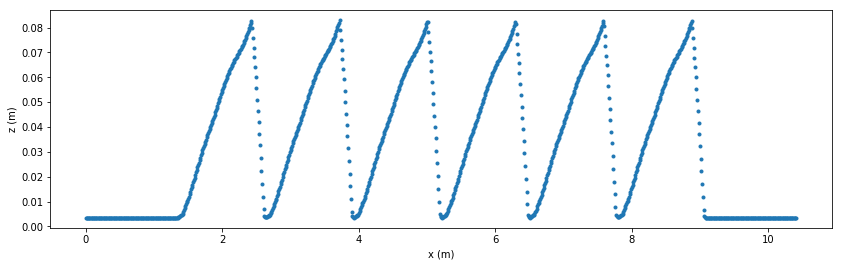

In [91]:
filepath = 'dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1000)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [92]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

qin  0.17960526315789474
num_dim: 1
Elevation at outlet
Mean U: 0.5748055494396328
Surface: 0.34850594869971585


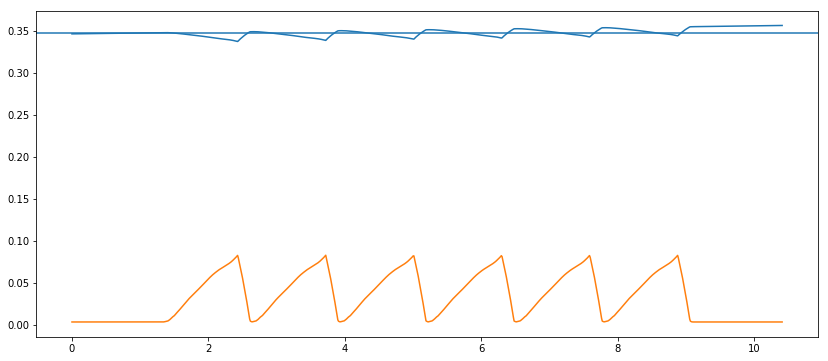

In [100]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut32, q32cm)
model.set_controller(tfinal = 300, num_output_times=10)
model.run()

h32 = model.get_hf()
u32 = model.get_uf()
surf32 = h32 + z0
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, surf32)
plt.plot(x0, z0)


print('Elevation at outlet'.format(surf32[len(x0)-1]))
print('Mean U: {0}'.format(model.get_uf().mean()))
print('Surface: {0}'.format(surf32.mean()))
plt.axhline(surf32.mean())

In [94]:


tau32 = [sedtrans.get_bed_shear(h32[i],u32[i],D50) for i in range(len(x0))]

qsb32_bagnold = [sedtrans.get_unit_bed_load_slope_shear(tau32[i], D50, None, rho_particle, 30, 'bagnold', False) for i in range(len(x0))]

qsb32_mpm = [sedtrans.get_unit_bed_load_slope_shear(tau32[i], D50, None, rho_particle, 30, 'mpm', False) for i in range(len(x0))]


def calculate_bedload(u,h, a=0.001, b=3.):
    qbedload = np.zeros(len(u))
    qbedload = (a*u*(u) **(b))
    return qbedload

def calculate_bedload_hogg(u,h, a=0.001, b=3.):
    qbedload = np.zeros(len(u))
    qbedload = (a*h*u*(u) **(b))
    return qbedload


    

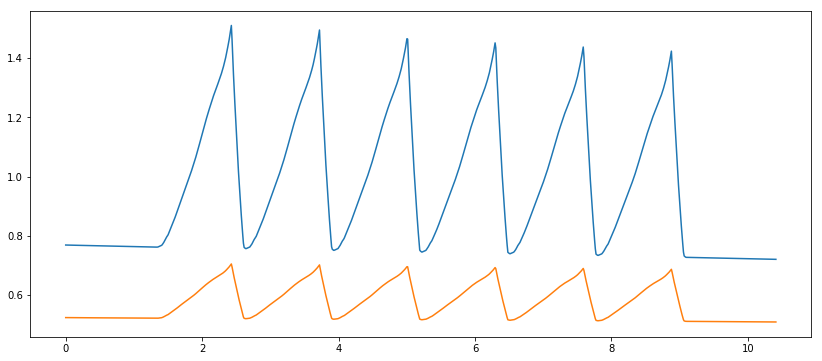

In [95]:
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, tau32)
plt.plot(x0, u32)

(3.2032061823020556e-06, 5.092907929205739e-06)

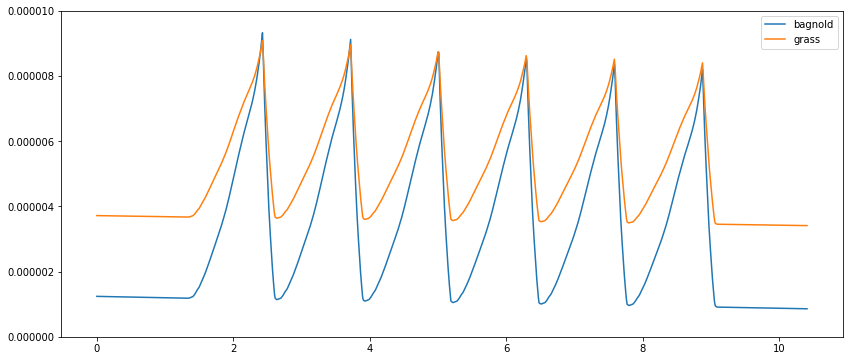

In [105]:
qsb32_hogg = calculate_bedload_hogg(u32, h32, a=0.000205, b=4)

qsb32_grass = calculate_bedload(u32, h32,  a=0.000026, b=2)

qsb32_grass.mean()

fig = plt.figure(figsize=(14, 6))
#plt.plot(x0, qsb_mpm, label='mpm')
plt.plot(x0, qsb32_bagnold, label='bagnold')
plt.plot(x0, qsb32_grass, label='grass')
#plt.plot(x0, qsb32_hogg, label='hogg')
plt.ylim([0,0.00001])
plt.legend()

np.array(qsb32_bagnold).mean(), np.array(qsb32_grass).mean()

qin  0.07894736842105263
num_dim: 1
2019-05-22 19:33:21,380 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-22 19:33:24,127 INFO CLAW: Solution 1 computed for time t=30.000000
2019-05-22 19:33:26,891 INFO CLAW: Solution 2 computed for time t=60.000000
2019-05-22 19:33:29,713 INFO CLAW: Solution 3 computed for time t=90.000000
2019-05-22 19:33:32,376 INFO CLAW: Solution 4 computed for time t=120.000000
2019-05-22 19:33:35,210 INFO CLAW: Solution 5 computed for time t=150.000000
2019-05-22 19:33:37,830 INFO CLAW: Solution 6 computed for time t=180.000000
2019-05-22 19:33:40,439 INFO CLAW: Solution 7 computed for time t=210.000000
2019-05-22 19:33:43,012 INFO CLAW: Solution 8 computed for time t=240.000000
2019-05-22 19:33:46,685 INFO CLAW: Solution 9 computed for time t=270.000000
2019-05-22 19:33:49,806 INFO CLAW: Solution 10 computed for time t=300.000000
Elevation at outlet
Mean U: 0.41535626827116245
Surface: 0.22919680382195445


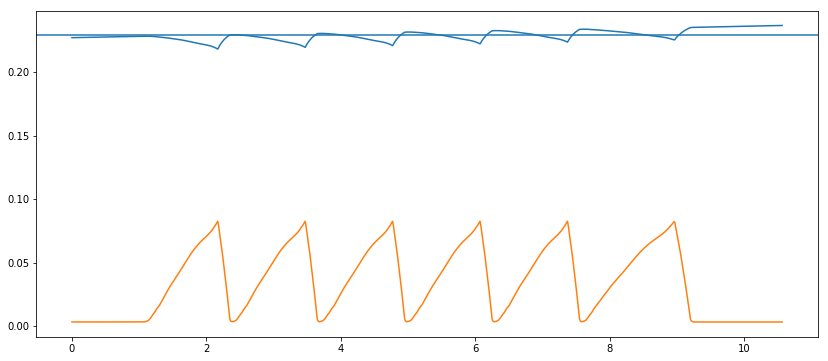

In [10]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, q20cm)
model.set_controller(tfinal = 300, num_output_times=10)
model.run()

h20 = model.get_hf()
u20 = model.get_uf()

surf20 = h20 + z0
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, surf20)
plt.plot(x0, z0)


print('Elevation at outlet'.format(surf20[len(x0)-1]))
print('Mean U: {0}'.format(model.get_uf().mean()))
print('Surface: {0}'.format(surf20.mean()))
plt.axhline(surf.mean())

In [11]:

qsb20_grass = calculate_bedload(u20,h20)

tau20 = [sedtrans.get_bed_shear(h20[i],u20[i],D50) for i in range(len(x0))]

qsb20_bagnold = [sedtrans.get_unit_bed_load_slope_shear(tau20[i], D50, None, rho_particle, 30, 'bagnold', False) for i in range(len(x0))]

qsb20_mpm = [sedtrans.get_unit_bed_load_slope_shear(tau20[i], D50, None, rho_particle, 30, 'mpm', False) for i in range(len(x0))]

(7.826493872039974e-07, 7.431838620585785e-07)

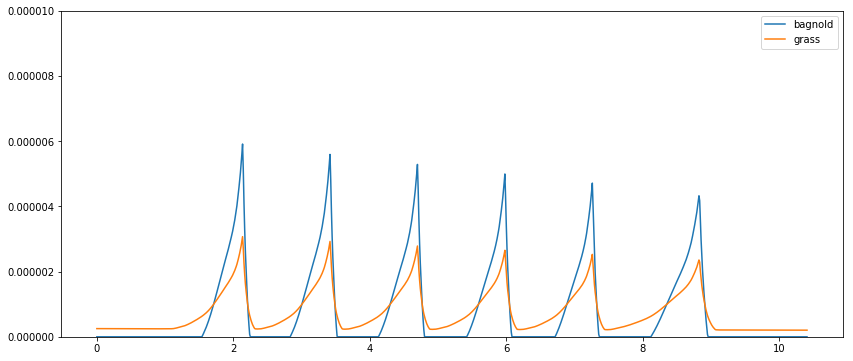

In [98]:
qsb20_hogg = calculate_bedload_hogg(u20, h20, a=0.000205, b=4)

qsb20_grass = calculate_bedload(u20,h20,  a=0.000046, b=4.)

fig = plt.figure(figsize=(14, 6))
#plt.plot(x0, qsb_mpm, label='mpm')
plt.plot(x0, qsb20_bagnold, label='bagnold')
plt.plot(x0, qsb20_grass, label='grass')
#plt.plot(x0, qsb20_hogg, label='hogg')
plt.ylim([0,0.00001])
plt.legend()

np.array(qsb20_bagnold).mean(), np.array(qsb20_grass).mean()

(7.826493872039974e-07, 1.3124246089112408e-06)